In [37]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, TimeDistributed, Input, Dropout, GRU
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from keras.saving import register_keras_serializable
from sklearn.metrics import r2_score

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-2 *look_back+1, look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back: i+ 2*look_back])
    return np.array(dataX), np.array(dataY)

def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

def read_data(file_path, num_features = 1):
    from pandas import read_csv
    series_influ_A_df = read_csv(file_path, index_col=0, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})
    series_influ_A_df = series_influ_A_df[["case", "humidity", "temp", "dew","windspeed", "tempmax",][:num_features]]
    return series_influ_A_df.dropna()

def prepare_data(series, look_back, scaler, is_ema = False):
    if is_ema:
        span = 52  # Bạn có thể điều chỉnh độ dài span tùy ý
        series['case'] = exponential_moving_average(series['case'], span)
    series = series.astype('float32')
    series = series.values
    if scaler is not None:
        flattened_dataset = series.flatten()
        dataset = scaler.fit_transform(flattened_dataset.reshape(-1,1))
        dataset = dataset.reshape(series.shape)

    else: 
        dataset = series

    rest = len(dataset) % look_back
    dataset = dataset[rest:, :]
    trainsize = len(dataset) - look_back
    train = dataset[:trainsize, :]
    test = dataset[trainsize - look_back:, :]

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    return trainX, trainY, testX, testY

def forecast(input, model):
    predicted = model.predict(input, verbose=0)
    return predicted


def save_plot(x,y, file_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats

    # Generate some sample data
    # x = y_inverse.flatten()
    # y = y_hat_inverse.flatten()

    # Compute the linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Create the R-squared line
    r2_line = slope * x + intercept
    r2 = r2_score(x, y)
    r2_pearson = r_value**2
    squared_error = np.square(x-y)

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label='Data Points')
    plt.plot(x, squared_error, color='red', marker="o", label=f'squared Error (R²={r2:.2f})')

    # Add labels and title
    plt.xlabel('actual number of infection')
    plt.ylabel('forecast number of infection')
    plt.title('Scatter Plot with R-squared Line')
    plt.legend()
    plt.grid()
    plt.savefig(file_path)
    plt.close()

def inverse_transform(data, scaler):
    flattened_data = data.flatten()
    inverse_flattened_data = scaler.inverse_transform(flattened_data.reshape(-1,1))
    return inverse_flattened_data.reshape(data.shape)

In [38]:
@register_keras_serializable()
class MyLSTM (Sequential):
    def __init__(self, look_back, dense_units =[],unit=64, optimizer='adam',name='lstm'):
        super().__init__(name=name)
        self.look_back = look_back
        self.add(Input(shape=(look_back,1)))
        self.add(LSTM(units=unit, activation='relu', return_sequences=True))
        for unit in dense_units:
            self.add(Dense(units=unit, activation='relu'))
        self.add(TimeDistributed(Dense(units=5, activation='sigmoid' )))
        self.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    

def build_model(input_shape, first_additional_layer, second_additional_layer, third_additional_layer, dropout=None, dense_units = [], unit=64, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=unit, return_sequences=True))
    model.add(Dropout(0.2))
    # Second LSTM layer
    if first_additional_layer:
        model.add(LSTM(units=unit, return_sequences=True))
        model.add(Dropout(0.2))
    # Third LSTM layer
    if second_additional_layer:
        model.add(GRU(units=unit, return_sequences=True))
        model.add(Dropout(0.2))
    # Fourth LSTM layer
    if third_additional_layer:
        model.add(GRU(units=unit, return_sequences=True))
        model.add(Dropout(0.2))

    # if first_additional_layer:
    #     model.add(LSTM(units=unit, return_sequences=True))
    #     model.add(Dropout(dropout))

    # if second_additional_layer:
    #     model.add(LSTM(units=unit, return_sequences=True))
    #     model.add(Dropout(dropout))

    # if third_additional_layer:
    #     model.add(GRU(units=unit, return_sequences=True))
    #     model.add(Dropout(dropout))
    for unit in dense_units:
        model.add(Dense(units=unit, activation='relu'))
    model.add(TimeDistributed(Dense(units=input_shape[1], activation='sigmoid' )))
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


In [39]:
def plot(testY, forecasts):
    import matplotlib.pyplot as plt
    forecastsPlot = forecasts[:,:,0].reshape(-1)
    testPlot = testY[:,:,0].reshape(-1)
    plt.plot(testPlot, "-y", label="actual", marker= '.')
    plt.plot(forecastsPlot, color = 'green', label="forecast")
    plt.ylabel("Number of infections")
    plt.legend(["actual", "forecast"])
    plt.show()


In [40]:
import itertools
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os, json
from keras.models import load_model


def LSTM_HyperParameter_Tuning(config, df, scaler):
    
    num_features, layers, n_neurons, n_batch_sizes, dropouts, look_backs, is_emas = config
    possible_combinations = list(itertools.product(num_features, layers, n_neurons, n_batch_sizes, dropouts, look_backs, is_emas))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    for i in range(0, len(possible_combinations)):
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        num_features, layers, n_neurons, n_batch_size, dropout, look_back, is_ema = possible_combinations[i]

        df = read_data('../temp_data/influA_vietnam_last_10_days.csv',num_features=num_features)
        
        trainX, trainY, testX, testY = prepare_data(df, look_back, scaler, is_ema=is_ema)
        model = build_model(
            input_shape=(trainX.shape[1], trainX.shape[2]),
            first_additional_layer= layers[0],
            second_additional_layer=layers[1],
            third_additional_layer=layers[2],
            dense_units=n_neurons[1:],
            unit=n_neurons[0])

        es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''
        a = 'ema' if is_ema else 'not_ema'
        lstm_dir = os.path.join("../result", f"""lstm_gru_{a}""")
        lstm_combination_dir = os.path.join(lstm_dir, str(i))
        os.makedirs(lstm_combination_dir, exist_ok=True)

        file_path = os.path.join(lstm_combination_dir, 'best_lstm_m2m_model.keras')

        mc = ModelCheckpoint(file_path, monitor='loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        model.fit(trainX, trainY,batch_size=n_batch_size, callbacks=[es, mc], verbose=0, epochs=200)
        train_accuracy = model.evaluate(trainX, trainY, verbose=0)
        # test_accuracy = model.evaluate(testX, testY, verbose=0)
        # hist.append(list((n_neurons, n_batch_size, dropout,look_back,
        #                   train_accuracy, test_accuracy)))
        hist.append(list((n_neurons, n_batch_size, dropout,look_back,
                          train_accuracy)))
        
        
        config= {
            "layers": layers,
            "units": n_neurons,
            "n_batch_size": n_batch_size,
            "dropout": dropout,
            "look_back": look_back,
            "is_ema": is_ema
        }
        with open(os.path.join(lstm_combination_dir,'config.json'), 'w') as f:
            json.dump(config, f)

        

        # print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy}')
        
        # print('--------------------------------------------------------------------')
        # print('--------------------------------------------------------------------')
        # print('--------------------------------------------------------------------')
        # print('--------------------------------------------------------------------')
    for i in range(0, len(possible_combinations)):

        num_features, layers, n_neurons, n_batch_size, dropout, look_back, is_ema = possible_combinations[i]
        df = read_data('../temp_data/influA_vietnam_last_10_days.csv',num_features=num_features)
        trainX, trainY, testX, testY = prepare_data(df, look_back, scaler, is_ema=is_ema)

        a = 'ema' if is_ema else 'not_ema'
        lstm_dir = os.path.join("../result", f"""lstm_gru_{a}""")
        lstm_combination_dir = os.path.join(lstm_dir, str(i))
        os.makedirs(lstm_combination_dir, exist_ok=True)

        file_path = os.path.join(lstm_combination_dir, 'best_lstm_m2m_model.keras')


        model = load_model(file_path)

        #TODO: save r square
        testY_hat = forecast(testX, model)
        y_hat_inverse = inverse_transform(testY_hat, scaler)
        y_inverse = inverse_transform(testY, scaler)

        r2_image_path = os.path.join(lstm_combination_dir, 'r2_image.png')
        save_plot(y_inverse[:,:,0].flatten(), y_hat_inverse[:,:,0].flatten(), r2_image_path)
        
    import pandas as pd
    hist_df = pd.DataFrame(hist)
    hist_df = hist_df.rename(columns={0: 'units', 1: 'batch_size', 2: 'dropout', 3: 'look_back', 4: 'train_loss'})
    hist_df = hist_df.sort_values(by=['train_loss'], ascending=True)
    hist_df.to_csv(os.path.join(lstm_dir, 'history.csv'))
    return hist_df

In [41]:

#TODO: [layers, units, batch_size, dropout, look_back, is_ema]
num_features = [1,2]
layers = [[False, True, True],[True, False, True]]
units = [[64]]
config = [num_features, layers, units, [1, 2, 4, 8], [0.2],[10,12,15,17], [True]] 
df = read_data('../temp_data/influA_vietnam_last_10_days.csv', num_features=1)
hist = LSTM_HyperParameter_Tuning(config, df, scaler)

[(1, [False, True, True], [64], 1, 0.2, 10, True), (1, [False, True, True], [64], 1, 0.2, 12, True), (1, [False, True, True], [64], 1, 0.2, 15, True), (1, [False, True, True], [64], 1, 0.2, 17, True), (1, [False, True, True], [64], 2, 0.2, 10, True), (1, [False, True, True], [64], 2, 0.2, 12, True), (1, [False, True, True], [64], 2, 0.2, 15, True), (1, [False, True, True], [64], 2, 0.2, 17, True), (1, [False, True, True], [64], 4, 0.2, 10, True), (1, [False, True, True], [64], 4, 0.2, 12, True), (1, [False, True, True], [64], 4, 0.2, 15, True), (1, [False, True, True], [64], 4, 0.2, 17, True), (1, [False, True, True], [64], 8, 0.2, 10, True), (1, [False, True, True], [64], 8, 0.2, 12, True), (1, [False, True, True], [64], 8, 0.2, 15, True), (1, [False, True, True], [64], 8, 0.2, 17, True), (1, [True, False, True], [64], 1, 0.2, 10, True), (1, [True, False, True], [64], 1, 0.2, 12, True), (1, [True, False, True], [64], 1, 0.2, 15, True), (1, [True, False, True], [64], 1, 0.2, 17, True),

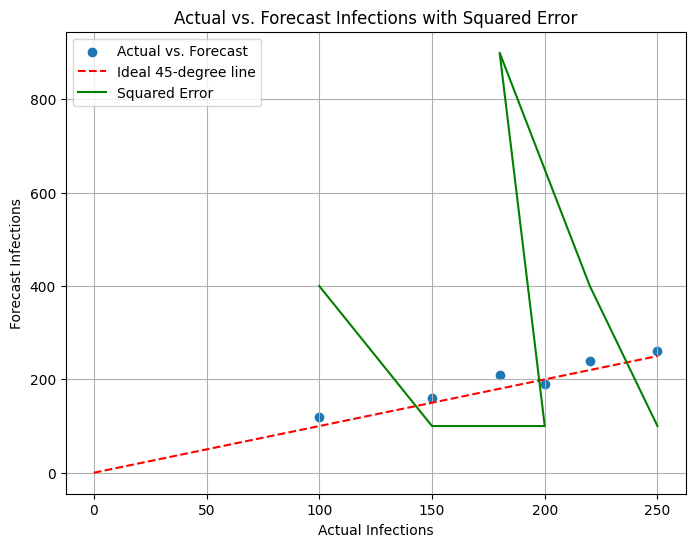

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
actual_infections = np.array([100, 150, 200, 180, 220, 250])
forecast_infections = np.array([120, 160, 190, 210, 240, 260])

# Calculate squared error
squared_error = np.square(actual_infections - forecast_infections)

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_infections, forecast_infections, label='Actual vs. Forecast')
plt.plot([0, max(actual_infections)], [0, max(actual_infections)], 'r--', label='Ideal 45-degree line')
plt.plot(actual_infections, squared_error, 'g-', label='Squared Error')

plt.xlabel('Actual Infections')
plt.ylabel('Forecast Infections')
plt.title('Actual vs. Forecast Infections with Squared Error')
plt.legend()
plt.grid()
plt.show()

<Axes: xlabel='Day'>

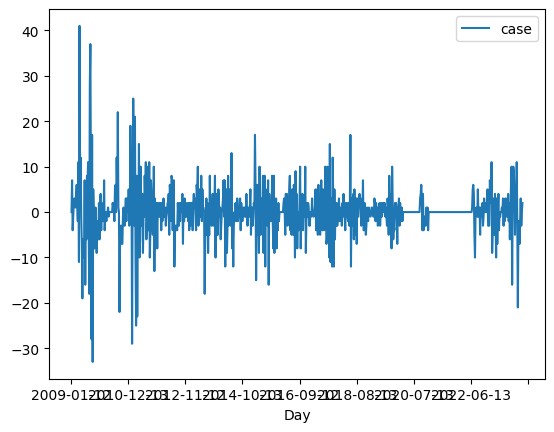

In [43]:
df = read_data('../temp_data/influA_vietnam_last_10_days.csv', num_features=1)
df.diff().plot()